In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download -d anthonysusevski/course-reviews-university-of-waterloo
! mkdir class_waterloo
! unzip course-reviews-university-of-waterloo.zip -d class_waterloo

  0% 0.00/1.25M [00:00<?, ?B/s]
100% 1.25M/1.25M [00:00<00:00, 107MB/s]
Archive:  course-reviews-university-of-waterloo.zip
  inflating: class_waterloo/course_data_clean.csv  


In [ ]:
 ! kaggle datasets download -d aashita/masks
 ! unzip masks.zip -d masks

  0% 0.00/2.10M [00:00<?, ?B/s]
100% 2.10M/2.10M [00:00<00:00, 59.5MB/s]
Archive:  masks.zip
  inflating: masks/comment.png       
  inflating: masks/loc.png           
  inflating: masks/masks-wordclouds/comment.png  
  inflating: masks/masks-wordclouds/loc.png  
  inflating: masks/masks-wordclouds/star.png  
  inflating: masks/masks-wordclouds/upvote.png  
  inflating: masks/masks-wordclouds/user.png  
  inflating: masks/star.png          
  inflating: masks/upvote.png        
  inflating: masks/user.png          


In [ ]:
!ls -ltr

total 3456
drwxr-xr-x 1 root root    4096 Dec  1 20:08 sample_data
-rw-r--r-- 1 root root      63 Dec  2 21:56 kaggle.json
-rw-r--r-- 1 root root 1313814 Dec  2 21:56 course-reviews-university-of-waterloo.zip
drwxr-xr-x 2 root root    4096 Dec  2 21:56 class_waterloo
-rw-r--r-- 1 root root 2206860 Dec  2 21:56 masks.zip
drwxr-xr-x 3 root root    4096 Dec  2 21:56 masks


In [ ]:
import string
import re
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import auc, accuracy_score, mean_squared_error
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, GridSearchCV,\
 KFold, RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB

import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
class_full_df = pd.read_csv("./class_waterloo/course_data_clean.csv")

## **EDA and Data Preprocessing**

In [ ]:
class_full_df.sort_values("num_ratings", ascending=False)

,course_code,course_title,num_ratings,useful,easy,liked,num_reviews,reviews,course_rating,course_rating_int
0,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,go to office hours and practice,liked course,1.0
55,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,Really easy course. Especially if you have cod...,liked course,1.0
63,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,Good course for my first CS course.,liked course,1.0
62,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,For someone with no history in writing program...,liked course,1.0
61,CS 115,Introduction to Computer Science 1,2111,21%,10%,23%,86,They teach Dr Racket in this course. No one ev...,liked course,1.0
...,...,...,...,...,...,...,...,...,...,...
14730,ENVS 433,Ecotourism and Communities,1,100%,100%,100%,1,Great course. Self-reflection and experiential...,liked course,1.0
14731,FINE 212,"Renaissance Art, 1300-1500",1,100%,75%,100%,1,Great course! the grades were fairly broken do...,liked course,1.0
14835,AFM 417,Special Topics in Accounting,0,NaN,NaN,NaN,1,Topic 3: Intro to Data Analytics,NaN,NaN
14836,ECON 472,Senior Honours Essay,0,100%,0%,NaN,1,Not sure if I liked this course yet. Definitel...,NaN,NaN


In [ ]:
# Get unique courses by area/department
def unique_courses(df, courses_column="course_code"):
  courses_all = df[courses_column].unique()
  courses_all = set([course.split(" ")[0] for course in courses_all])
  return courses_all

courses_all = unique_courses(class_full_df)
print(courses_all)

{'ME', 'GEOG', 'ANTH', 'KOREA', 'RUSS', 'SWREN', 'ESL', 'CLAS', 'THPERF', 'GRK', 'SYDE', 'AHS', 'DAC', 'MGMT', 'ACC', 'GBDA', 'SDS', 'SI', 'APPLS', 'LAT', 'RS', 'ARCH', 'COOP', 'PMATH', 'ITAL', 'CIVE', 'HIST', 'CHINA', 'INDEV', 'ITALST', 'ERS', 'CHE', 'BME', 'CROAT', 'SEQ', 'AVIA', 'BUS', 'PHARM', 'BIOL', 'STV', 'MNS', 'GER', 'GEOE', 'KIN', 'PSCI', 'SCBUS', 'ACINTY', 'SCI', 'INTST', 'FR', 'PD', 'LS', 'MTE', 'STAT', 'REES', 'ASL', 'HRM', 'ECE', 'REC', 'JS', 'PORT', 'PSYCH', 'GSJ', 'AMATH', 'GENE', 'INDG', 'FINE', 'CFM', 'SE', 'PLAN', 'VCULT', 'SOCWK', 'MATH', 'HLTH', 'PACS', 'COGSCI', 'SVENT', 'ARABIC', 'SPAN', 'ENBUS', 'EASIA', 'ARBUS', 'EMLS', 'INTEG', 'DUTCH', 'BASE', 'AFM', 'SOC', 'MUSIC', 'CS', 'PHIL', 'NE', 'MSCI', 'ARTS', 'PHYS', 'ENGL', 'WKRPT', 'EARTH', 'WS', 'ISS', 'CHEM', 'ENVE', 'ECON', 'ACTSC', 'JAPAN', 'HUMSC', 'GERON', 'ENVS', 'SMF', 'MTHEL', 'COMM', 'CO', 'BET', 'SPCOM', 'DRAMA'}


In [ ]:
# Get % of liked
def get_balance(df, pivot_column="course_rating_int"):
  """Get the percentage of liked and didn't like
  """

  total_reviews = len(df[pivot_column])
  total_pos = round((len(df[df[pivot_column] == 1.0])/total_reviews)*100, 2)
  total_neg = round((len(df[df[pivot_column] == 0.0])/total_reviews)*100, 2)
  
  return total_pos, total_neg


# Get % of liked per course
def get_df_liked(df, courses, courses_column="course_code"):
  """Get a DataFrame
  """

  df_liked = {"course":[], "liked":[], "didnt":[], "diff":[],}
  for course in courses_all:
    class_df = df[df[courses_column].str.match(course, case=False)]
    total_pos, total_neg = get_balance(class_df)
    df_liked["course"].append(course)
    df_liked["liked"].append(total_pos)
    df_liked["didnt"].append(total_neg)
    if abs(total_pos - total_neg) <= 20.0:
      df_liked["diff"].append(1.0)
    else:
      df_liked["diff"].append(0.0)

  return df_liked


df_liked = pd.DataFrame(get_df_liked(class_full_df, list(courses_all)))
df_liked.sort_values("diff", ascending=False)

,course,liked,didnt,diff
30,ERS,47.92,52.08,1.0
102,ECON,54.95,43.37,1.0
32,BME,57.01,42.99,1.0
82,EMLS,53.85,46.15,1.0
37,PHARM,42.86,57.14,1.0
...,...,...,...,...
36,BUS,34.62,65.38,0.0
35,AVIA,82.35,11.76,0.0
34,SEQ,100.00,0.00,0.0
31,CHE,67.94,30.34,0.0


### **Filter by course code**

In [ ]:
# Filter by course code
rgex = 'BIOL|PHYS'

def filter_corpus(df, filter_by="course_code", rgex=None):
  """Get a filtered df of n by 2 dimension 

  :parm rgex: The filter rgex.
  """
  
  if rgex:
    df = df[df[filter_by].str.match(rgex, case=False)]
    print("Filtered by: {}".format(rgex))

  df = df[["reviews", "course_rating_int"]]
  
  print("Total of instances: {}; \
  Total of features: {}".format(df.shape[0], df.shape[1]))

  return df


class_df = filter_corpus(df=class_full_df, rgex=rgex)
display(class_df.head())

Filtered by: BIOL|PHYS
Total of instances: 1363;   Total of features: 2


,reviews,course_rating_int
2576,"online in fall 2021, felt kind of disorganized...",0.0
2577,I absolutely disliked this course. I took it o...,0.0
2578,"This course is tedious in terms of detail, but...",1.0
2579,"The course itself was fairly easy, although di...",1.0
2580,Course content was easy but disconnected. I ha...,0.0


In [ ]:
# Remove rows w/null values
total_null = class_df.isnull().sum()
print("Total of null values: {}".format(total_null))

class_df.dropna(inplace=True)
class_df.reset_index(inplace=True)
class_df.isnull().sum()

Total of null values: reviews               1
course_rating_int    20
dtype: int64


index                0
reviews              0
course_rating_int    0
dtype: int64

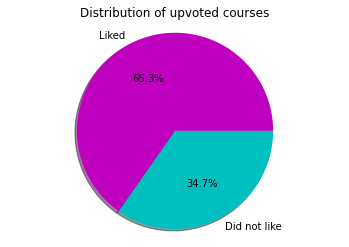

In [ ]:
def pie_plot(sizes, labels=["Liked", "Did not like"], title="Title"):
  fig, ax1 = plt.subplots()
  ax1.pie(sizes, labels=labels, shadow=True, autopct='%1.1f%%',
          colors=["m", "c"])
  ax1.axis("equal")
  plt.title(title)
  plt.show()


total_pos, total_neg = get_balance(class_df, \
                                   pivot_column="course_rating_int")
pie_plot([total_pos, total_neg], title="Distribution of upvoted courses")

In [ ]:
# Split data
X = class_df["reviews"]
y = class_df["course_rating_int"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=520)

In [ ]:
# Preprocess data

stopwords = nltk.corpus.stopwords.words("english")
stopwords = stopwords + ["u", "im", "c", "abc"] # From kaggle

def preproc_token(text, lemma=True, ngrams=False):
  # lowercase
  text_clean = text.lower()
  
  # remove punctuation
  text_clean = "".join([char for char in
                        text_clean if char not in string.punctuation])
  
  # remove numbers
  text_clean = re.sub('\w*\d\w*', '', text_clean)
  
  # remove any symbols out of U.S. ASCII, e.g, 'よく頑張らなければいけ 😓'
  rgx = re.compile(r"(\w*[\u0080-\u07FF]+)\w*|\w+([\u0800-\uFFFF]+)\w*|\w*([\U00010000-\U0010FFFF]+)\w*")
  text_clean = re.sub(rgx, "", text_clean)

  # tokenize
  text_clean = re.split("\W+", text_clean)

  # remove stopwords
  if lemma == True:
    # lemmatizing
    lemmas = nltk.WordNetLemmatizer()
    text_clean = [lemmas.lemmatize(word) for word in 
                  text_clean if word not in stopwords] 
  else:
    # stemming
    stemmer = nltk.PorterStemmer()
    text_clean = [stemmer.stem(word) for word in
                  text_clean if word not in stopwords]

  # remove "orphan letters" and len(word)<=2
  text_clean = ["" if len(word)<=2 else word for word in text_clean]

  if ngrams == True:
    text_clean = " ".join([word for word in text_clean])

    
  return text_clean

# X_train = X_train.apply(lambda x: preproc_token(x))
# X_test = X_test.apply(lambda x: preproc_token(x))
# display(X_train[300])

### **Visualization of tokens**

In [ ]:
_tokens_vis = pd.DataFrame(class_df["reviews"].apply(lambda x: preproc_token(x)))
_tokens_vis["label"] = class_df["course_rating_int"]

def top_tokens(df, label=1.0, top=10, label_column="label", text_column="reviews"):
  """Get the 10 most frequent tokens corresponding to the picked label.
  
  Adapted from Kaggle
  https://www.kaggle.com/code/andreshg/nlp-glove-bert-tf-idf-lstm-explained#4.-Tokens-visualization-%F0%9F%93%8A
  
  :param label: The label to which the text is pivoted. 
  :type label: float
  :param top: How many items will be selected from high to low frequency.
  :type top: int
  :returns: A dictionary of the 10 most frequent tokens.
  :rtype: dict
  """
  
  # Concatenate lists of texts (e.g., reviews)
  corpus = []
  for text in df[df[label_column]==label]["reviews"]:
    corpus = corpus + text

  # Get dictionary {word:frequency}
  dict_corpus = defaultdict(int)
  for token in corpus:
    dict_corpus[token]+=1

  # Get `top` most frequent tokens:
  top_tokens = sorted(dict_corpus.items(), 
                      key=lambda x:x[1], reverse=True)[:int(top)]


  return top_tokens

# top_tokens = top_tokens(_tokens_vis, label=1.0, top=10, label_column="label", text_column="reviews")
# print(top_tokens)



In [ ]:
_tokens_vis

,reviews,label
0,"[online, fall, felt, kind, disorganized, wasnt...",0.0
1,"[absolutely, disliked, course, took, online, f...",0.0
2,"[course, tedious, term, detail, personally, en...",1.0
3,"[course, fairly, easy, although, difficult, ti...",1.0
4,"[course, content, easy, disconnected, hate, qu...",0.0
...,...,...
1337,"[really, interesting, course, especially, curi...",1.0
1338,"[really, well, assignment, work, together, gro...",1.0
1339,"[refreshing, course, take, taken, upper, year,...",1.0
1340,"[good, course, well, structured]",1.0


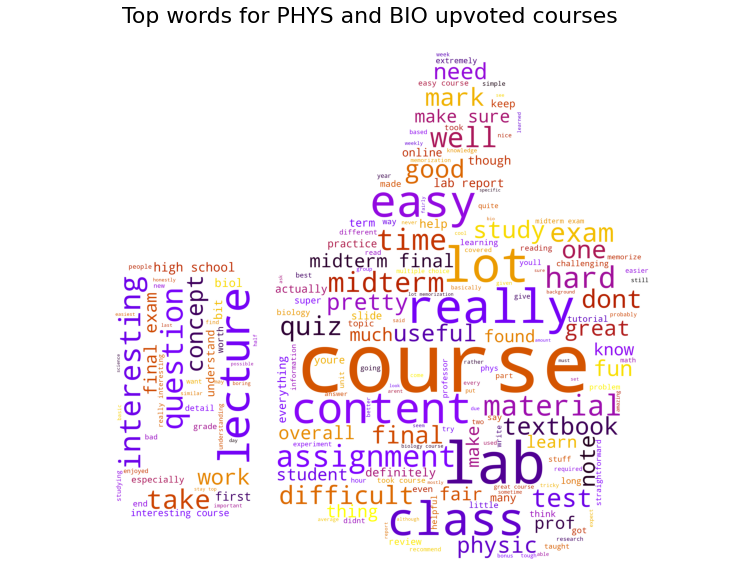

In [ ]:
im_dir = './masks/upvote.png'

def get_masked(df, dir, n=200, label_val=1.0, label_column="label", \
               feature_column="reviews", title="Word Cloud", \
               cloud_color="gnuplot"):
  """Generate a word cloud for n words wrt the given label.
  
  :param df: The dataframe containing the text and labels. 
  :type df: pandas DataFrame
  :param dir: The directory where the mask is allocated. =
  :type dir: str
  :param n: The anumber of words to be displayed. 
  :type n: int
  :param label_val: The value of the value to filter the text.
  :type label_val: float
  :param label_column: The column name of the label. 
  :type label_column: str
  :param feature_column: The feature containing the text.
  :type feature_column: str
  :param title: The title of the word cloud image.
  :type title: str
  :param cloud_color: A matplot colormap type.
  :type cloud_Color: str
  :returns: None
  :rtype: matplotlib object
  """
  
  im_mask = np.array(Image.open(dir))
  wc = WordCloud(
    background_color='white', 
    max_words=n, 
    mask=im_mask,
    colormap=cloud_color,
    )
  
  corpus = []
  for lst in df[df[label_column]==label_val][feature_column]:
    corpus += lst
  
  corpus = ' '.join(word for word in corpus)
  wc.generate(corpus)
  plt.figure(figsize=(18,10))
  plt.title(title, fontdict={'size': 22,  'verticalalignment': 'bottom'})
  plt.imshow(wc, cmap=cloud_color)
  plt.axis("off")
  plt.show()

get_masked(_tokens_vis, im_dir, n=200, label_val=1.0, label_column="label", \
               feature_column="reviews", title="Top words for PHYS and BIO upvoted courses")


## **Vectorization**

### **1. Count vectorizer**

In [ ]:
# Vectorize using CountVectorizer
cv = CountVectorizer(analyzer=preproc_token)
X_train_cv = cv.fit_transform(X_train)
X_train_cv = X_train_cv.toarray()

X_test_cv = cv.transform(X_test)
X_test_cv = X_test_cv.toarray()


display(pd.DataFrame(X_train_cv, columns=cv.get_feature_names_out()))

,,ability,able,absolute,absolutely,absorb,abstract,absurd,abuse,academia,...,yet,yevick,youd,youll,youre,youtube,youve,yuri,zero,zoology
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,2,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **2. Count vectorizer & n-grams**

In [ ]:
# Vectorize using N-grams
# to provide more context

cv_ngrams = CountVectorizer(ngram_range=(2,2)) # Only consider bigrams

X_train_ngrams = X_train.apply(lambda x: preproc_token(x, ngrams=True))
X_train_ngrams = cv_ngrams.fit_transform(X_train_ngrams)
X_train_ngrams = X_train_ngrams.toarray()


X_test_ngrams = X_test.apply(lambda x: preproc_token(x, ngrams=True))
X_test_ngrams = cv_ngrams.transform(X_test_ngrams)
X_test_ngrams = X_test_ngrams.toarray()


display(pd.DataFrame(X_train_ngrams, columns=cv_ngrams.get_feature_names_out()))

,ability amass,ability derive,ability design,ability especially,ability finish,able apply,able break,able devote,able dsm,able every,...,zero experience,zero feedback,zero instruction,zero lab,zero leniency,zero python,zero relevance,zero useful,zoology biol,zoology course
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### **3. Term frequency–inverse document frequency (TF-IDF)**

In [ ]:
# Vectorize using TF-IDF
td = TfidfVectorizer(analyzer=preproc_token)

X_train_td = td.fit_transform(X_train)
X_train_td = X_train_td.toarray()

X_test_td = td.transform(X_test)
X_test_td = X_test_td.toarray()

print("Total of instances: {}, \
Total of features: {}".format(X_train_td.shape[0], X_train_td.shape[1]))

display(pd.DataFrame(X_train_td, columns=td.get_feature_names_out()))


Total of instances: 1006, Total of features: 3318


,,ability,able,absolute,absolutely,absorb,abstract,absurd,abuse,academia,...,yet,yevick,youd,youll,youre,youtube,youve,yuri,zero,zoology
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.133337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.451639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1002,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.170184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.165508,0.0,0.0,0.0,0.0,0.0,0.0
1004,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_train.iloc[4]

'I found this course to be very difficult. I took 11/12 biology, but the course is in so much more detail than was taught in high school. The multiple choice midterms and exam were also difficult. Many questions were set up like this: a) ____ b) _____ c) _____ d) a & c e) a, b, & c .'

In [ ]:
# GloVe


# **Modeling**


## **1. XGBoost**

In [ ]:
def get_best_cv(X_train, y_train, X_test,  y_test, predictor, params):
  """
  """
  pred = GridSearchCV(predictor, param_grid=params, n_jobs=-1)

  pred = pred.fit(X_train, y_train)
  pred_best = pred.best_estimator_
  pred_best_parms = pred.get_params()


  return pred_best, pred_best_parms


def get_pred(X_test, y_test, predictor):
  """
  """
  yhat = predictor.predict(X_test)
  pred_acc = accuracy_score(y_test, yhat)

  return pred_acc, yhat


def get_conf_matrix(X_test, y_test, predictor, col_map="BuPu", font_size=15):
  """
  """
  disp = ConfusionMatrixDisplay.from_estimator(predictor, X_test, y_test,
                                display_labels=predictor.classes_,
                                cmap=col_map)

  plt.title("XGBoost Confusion Matrix")
  plt.rcParams.update({'font.size': font_size})
  plt.show()

### **1.a. Count vectorizer**

Best parms using count vectorizing:{'cv': None, 'error_score': nan, 'estimator__base_score': 0.5, 'estimator__colsample_bylevel': 1, 'estimator__colsample_bynode': 0.8, 'estimator__colsample_bytree': 1, 'estimator__gamma': 0, 'estimator__learning_rate': 1, 'estimator__max_delta_step': 0, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__missing': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': 1, 'estimator__nthread': None, 'estimator__objective': 'binary:logistic', 'estimator__random_state': 520, 'estimator__reg_alpha': 0, 'estimator__reg_lambda': 1, 'estimator__scale_pos_weight': 1, 'estimator__seed': None, 'estimator__silent': None, 'estimator__subsample': 0.8, 'estimator__verbosity': 1, 'estimator__verbose': 1, 'estimator': XGBRFClassifier(random_state=520, verbose=1), 'n_jobs': -1, 'param_grid': {'n_estimators': [20, 30, 40, 50, 60, 70, 80, 90], 'max_depth': [10, 20, 100], 'learning_rate': [0.1], 'cv': [5, 10]}, 'pre_dispatch': '2*n_jobs', 'refit'

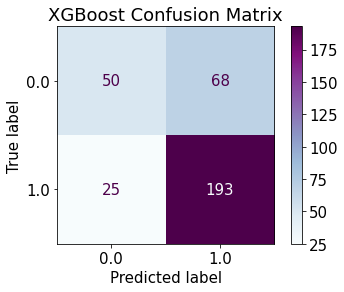

In [ ]:
xgb_cv = xgb.XGBRFClassifier(random_state=520, verbose=1)
xgb_parms_cv = {"n_estimators": list(range(20, 100, 10)), \
             "max_depth": [10, 20, 100], \
             "learning_rate": [0.1], 
             "cv": [5, 10]}


# Get best predictor
pred_best_cv, pred_best_parms_cv = get_best_cv(X_train_cv, y_train, X_test_cv, \
                        y_test, xgb_cv, xgb_parms_cv)

print("Best parms using count vectorizing:{}".format(pred_best_parms_cv))


# Get accuracy on test data
pred_acc_cv, yhat_cv = get_pred(X_test_cv, y_test, pred_best_cv)
print("\nAccuracy of count vectorizing:{}\n".format(pred_acc_cv))

# Get test data confusion matrix
get_conf_matrix(X_test_cv, y_test, pred_best_cv)

### **1.b. n-gram**

Best parms using count vectorizing:{'cv': None, 'error_score': nan, 'estimator__base_score': 0.5, 'estimator__colsample_bylevel': 1, 'estimator__colsample_bynode': 0.8, 'estimator__colsample_bytree': 1, 'estimator__gamma': 0, 'estimator__learning_rate': 1, 'estimator__max_delta_step': 0, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__missing': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': 1, 'estimator__nthread': None, 'estimator__objective': 'binary:logistic', 'estimator__random_state': 520, 'estimator__reg_alpha': 0, 'estimator__reg_lambda': 1, 'estimator__scale_pos_weight': 1, 'estimator__seed': None, 'estimator__silent': None, 'estimator__subsample': 0.8, 'estimator__verbosity': 1, 'estimator__verbose': 1, 'estimator': XGBRFClassifier(random_state=520, verbose=1), 'n_jobs': -1, 'param_grid': {'n_estimators': [20, 50, 100], 'max_depth': [10, 20, 100], 'learning_rate': [0.1], 'cv': [5]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_s

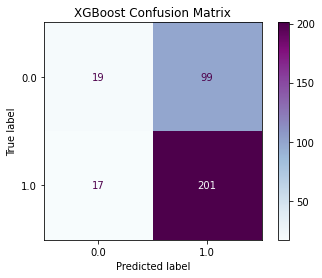

In [ ]:
xgb_ngrams = xgb.XGBRFClassifier(random_state=520, verbose=1)

xgb_parms_ngrams = {"n_estimators": [20, 50, 100], \
             "max_depth": [10, 20, 100], \
             "learning_rate": [0.1], 
             "cv": [5]}


# Get best predictor
pred_best_ngrams, pred_best_parms_ngrams = get_best_cv(X_train_ngrams, y_train, X_test_ngrams,
                        y_test, xgb_ngrams, xgb_parms_ngrams)

print("Best parms using count vectorizing:{}".format(pred_best_parms_ngrams))


# # Get accuracy on test data
pred_acc_ngrams, yhat_ngrams = get_pred(X_test_ngrams, y_test, pred_best_ngrams)
print("Accuracy of count vectorizing:{}".format(pred_acc_ngrams))

# # Get test data confusion matrix
get_conf_matrix(X_test_ngrams, y_test, pred_best_ngrams)

### **1.c. TF-IDF**

Also tested:
- n_estimators: 20, 30, 50, 60, 100
- max_depth: 3, 10, 50
- learning_rate : 0.001, 0.01, 0.05, 1.0

Best parms using count vectorizing:{'cv': None, 'error_score': nan, 'estimator__base_score': 0.5, 'estimator__colsample_bylevel': 1, 'estimator__colsample_bynode': 0.8, 'estimator__colsample_bytree': 1, 'estimator__gamma': 0, 'estimator__learning_rate': 1, 'estimator__max_delta_step': 0, 'estimator__max_depth': 3, 'estimator__min_child_weight': 1, 'estimator__missing': None, 'estimator__n_estimators': 100, 'estimator__n_jobs': 1, 'estimator__nthread': None, 'estimator__objective': 'binary:logistic', 'estimator__random_state': 520, 'estimator__reg_alpha': 0, 'estimator__reg_lambda': 1, 'estimator__scale_pos_weight': 1, 'estimator__seed': None, 'estimator__silent': None, 'estimator__subsample': 0.8, 'estimator__verbosity': 1, 'estimator': XGBRFClassifier(random_state=520), 'n_jobs': -1, 'param_grid': {'n_estimators': [50], 'max_depth': [10, 20, 100], 'learning_rate': [0.1], 'cv': [5]}, 'pre_dispatch': '2*n_jobs', 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 0}


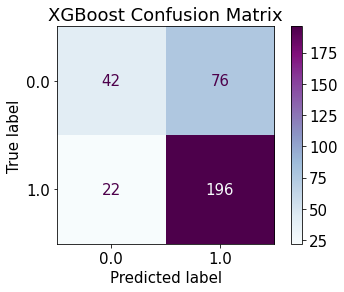

In [ ]:
xgb_td = xgb.XGBRFClassifier(random_state=520)


xgb_parms_td = {"n_estimators": [50], \
             "max_depth": [10, 20, 100], \
             "learning_rate": [0.1], 
             "cv": [5]}


# xgb_gs = GridSearchCV(xgb_model, param_grid=xgb_parms, n_jobs=-1)


# xgb_gs = xgb_gs.fit(X_train_td, y_train)
# xgb_gs_best = xgb_gs.best_estimator_

# yhat_xgb = xgb_gs_best.predict(X_test_td)
# acc_xgb = accuracy_score(y_test, yhat_xgb)

# disp = ConfusionMatrixDisplay.from_estimator(xgb_gs_best, X_test_td, y_test,
#                               display_labels=xgb_gs_best.classes_,
#                               cmap="BuPu")

# plt.title("XGBoost Confusion Matrix")
# plt.rcParams.update({'font.size': 20})
# plt.show()

# print("Accuracy :{}".format(acc_xgb))

# Get best predictor
pred_best_td, pred_best_parms_td = get_best_cv(X_train_td, y_train,
                                                       X_test_td, y_test,
                                                       xgb_td, xgb_parms_td)

print("Best parms using count vectorizing:{}".format(pred_best_parms_td))


# # Get accuracy on test data
pred_acc_td, yhat_td = get_pred(X_test_td, y_test, pred_best_td)
print("Accuracy of count vectorizing:{}".format(pred_acc_td))

# # Get test data confusion matrix
get_conf_matrix(X_test_td, y_test, pred_best_td)


## **2. Bayes**

### **1.a. n-gram**

0.7172619047619048


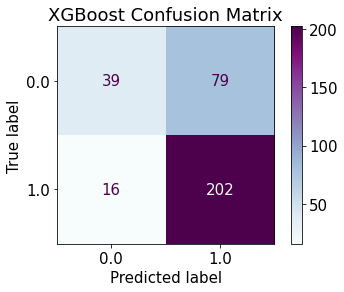

In [ ]:
# Multinomial Naive Bayes model
nb_td = MultinomialNB(alpha=0.1)

# Train the model
nb_td.fit(X_train_td, y_train)

# Get accuracy on test data
y_pred_td = nb_td.predict(X_test_td)

print(accuracy_score(y_test, y_pred_td))
get_conf_matrix(X_test_td, y_test, nb_td)

0.7053571428571429


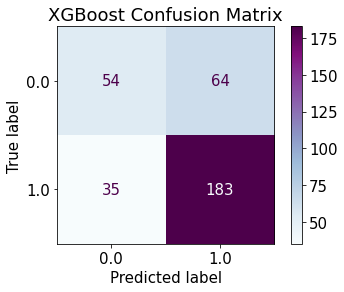

In [ ]:
# Multinomial Naive Bayes model
nb = MultinomialNB(alpha=0.1)

# Train the model
nb.fit(X_train_ngrams, y_train)

# Get accuracy on test data
y_pred_nb = nb.predict(X_test_ngrams)

print(accuracy_score(y_test, y_pred_nb))
get_conf_matrix(X_test_ngrams, y_test, nb)

## **3. LSTM and NN**

In [ ]:
# longest_train = max(X_train_td, key=lambda sentence: len(word_tokenize(sentence)))
# length_long_sentence = len(word_tokenize(longest_train))

In [ ]:
vocab_size = 10_000
embedding_dim = 3
max_length = 3318

In [ ]:
# Create and compile model
nn_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, \
                              input_length=max_length), # Get dense vector
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, \
                                                       return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(10)), # Last layer, no return_sequence activated 
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])

## compile model
nn_model.compile(loss="binary_crossentropy", optimizer="adam", \
                 metrics=["accuracy"]) # or tf.keras.optimizers.Adam(learning_rate=1e-2)
nn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3318, 3)           30000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 3318, 100)        21600     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 20)               8880      
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
Total params: 60,701
Trainable params: 60,701
Non-trai

In [ ]:
# train the model
num_epochs = 10

history = nn_model.fit(
    X_train_td, 
    y_train,
    epochs=num_epochs,
    validation_data=(X_test_td, y_test)
)

Epoch 1/10
32/32 [==============================] - 242s 7s/step - loss: 0.6579 - accuracy: 0.6541 - val_loss: 0.6486 - val_accuracy: 0.6488
Epoch 2/10
32/32 [==============================] - 229s 7s/step - loss: 0.6464 - accuracy: 0.6541 - val_loss: 0.6482 - val_accuracy: 0.6488
Epoch 3/10
32/32 [==============================] - 229s 7s/step - loss: 0.6455 - accuracy: 0.6541 - val_loss: 0.6482 - val_accuracy: 0.6488
Epoch 4/10
32/32 [==============================] - 228s 7s/step - loss: 0.6453 - accuracy: 0.6541 - val_loss: 0.6486 - val_accuracy: 0.6488
Epoch 5/10
32/32 [==============================] - 229s 7s/step - loss: 0.6451 - accuracy: 0.6541 - val_loss: 0.6488 - val_accuracy: 0.6488
Epoch 6/10
32/32 [==============================] - 228s 7s/step - loss: 0.6463 - accuracy: 0.6541 - val_loss: 0.6484 - val_accuracy: 0.6488
Epoch 7/10
32/32 [==============================] - 229s 7s/step - loss: 0.6456 - accuracy: 0.6541 - val_loss: 0.6482 - val_accuracy: 0.6488
Epoch 8/10
32

In [ ]:
def plot_learn(metric_type):
  """Plot metric against epochs. From 
  """
  plt.plot(history.history[metric_type])
  plt.plot(history.history["val_" + metric_type])
  plt.legend([metric_type, "val_" + metric_type])
  plt.xlabel("Epochs")
  plt.ylabel(metric_type)
  plt.show()

In [ ]:
plot_learn("accuracy")
plot_learn("loss")

In [ ]:
new_sentence = ["One of my most favorite courses", "A bad course"]

# preprocess new_sentence
# new_seqs = tokenizer.texts_to_sequences(new_sentence)
# new_pad_seqs = pad_sequences(new_seqs, 
#                              maxlen=max_length,
#                              padding=padding_type,
#                              truncating=trunc_type)

X_new_td = td.transform(new_sentence)
X_new_td = X_new_td.toarray()



new_predict = nn_model.predict(X_new_td)
print("Prediction for new sentence: {}".format(new_predict))